# Evaluate the Forward Neural network

reload the forward model and its training history and evaluate

## Import modules

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

2025-03-12 09:21:42.454910: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-12 09:21:42.462115: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-12 09:21:42.470165: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-12 09:21:42.472605: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-12 09:21:42.478922: I tensorflow/core/platform/cpu_feature_guar

## Set dynamic GPU memory growth

In [3]:
# Check if GPU available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("GPU is available and set to memory growth mode.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")

GPU is available and set to memory growth mode.


### Define the own resblock class

keras requires custom classes to be defined for being able to reload

In [4]:
# decorator to register the custom resblock to allow serialziation and re-loading
@keras.utils.register_keras_serializable()  # for keras3
class ResBlock1D(keras.Model):
    def __init__(self, filters, kernel_size=3, convblock=False, **kwargs):
        super(ResBlock1D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size

        # setup all necessary layers
        self.conv1 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn1 = keras.layers.BatchNormalization()
        self.conv2 = keras.layers.Conv1D(filters, kernel_size, padding="same")
        self.bn2 = keras.layers.BatchNormalization()
        # self.relu = keras.layers.LeakyReLU()
        self.relu = keras.layers.LeakyReLU(negative_slope=0.01)

        self.convblock = convblock
        if self.convblock:
            self.conv_shortcut = keras.layers.Conv1D(filters, 1)

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.bn1(x, training=training)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x, training=training)

        # add shortcut. optionally pass it through a Conv
        if self.convblock:
            x_sc = self.conv_shortcut(input_tensor)
        else:
            x_sc = input_tensor
        x += x_sc
        return self.relu(x)

    def get_config(self):
        base_config = super().get_config()
        return {
            "convblock": self.convblock,
            "filters": self.filters,
            "kernel_size": self.kernel_size,
            **base_config,
        }

## Load preprocessed data

In [5]:
hdf5_file_name = "datasets/core_shell_particles_preprocessed_122500.h5"

f = h5py.File(hdf5_file_name, "r")
X_train = np.array(f["X_train"])
y_train = np.array(f["y_train"])
X_test = np.array(f["X_test"])
y_test = np.array(f["y_test"])
f.close()

## Reload the forward model

In [6]:
model_filename = "models/resnet_Mie_predictor.keras"
model = keras.models.load_model(model_filename)

I0000 00:00:1741767713.388776  573593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741767713.391275  573593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741767713.392584  573593 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1741767713.490623  573593 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

## Reload training history

In [7]:
# path for loading the history
history_save_path = os.path.splitext(model_filename)[0] + "_hist.pkl"

# Load the history
with open(history_save_path, "rb") as f:
    history = pickle.load(f)

### Evaluate the model on the test set

In [8]:
test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)

print(f"Test Loss: {test_loss}")
print(f"y_pred: {y_pred.shape}")

I0000 00:00:1741767718.578508  573838 service.cc:146] XLA service 0x736c100061f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741767718.578530  573838 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2025-03-12 09:21:58.606428: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-03-12 09:21:58.703240: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


41/79 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.8909e-05

I0000 00:00:1741767719.176008  573838 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.1846e-05
79/79 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step
Test Loss: 5.615205009235069e-05
y_pred: (2500, 64, 2)


## Re-scale to physical units

We now use the saved pre-processing scalers to scale the predictions back to physical units

### reload the data scalers

In [9]:
# preprocessor path
preprocessor_path = "datasets/scaler_particle_geometries.pkl"
scaler_Qfwd_path = "datasets/scaler_Qfwd.pkl"
scaler_Qback_path = "datasets/scaler_Qback.pkl"

# Load the preprocessors and scalers
with open(preprocessor_path, "rb") as f:
    preprocessor = pickle.load(f)
with open(scaler_Qfwd_path, "rb") as f:
    scaler_Qfwd = pickle.load(f)
with open(scaler_Qback_path, "rb") as f:
    scaler_Qback = pickle.load(f)

In [10]:
# Separate predictions for Qfwd and Qback
y_pred_Qfwd = y_pred[..., 0]  # First output for Qfwd predictions
y_pred_Qback = y_pred[..., 1]  # Second output for Qback predictions

# Inverse transform the predictions to their original scale
y_pred_Qfwd_inverse = scaler_Qfwd.inverse_transform(y_pred_Qfwd)
y_pred_Qback_inverse = scaler_Qback.inverse_transform(y_pred_Qback)

# Apply expm1 to revert the log1p transformation
y_pred_Qfwd_orig_scale = np.expm1(y_pred_Qfwd_inverse)
y_pred_Qback_orig_scale = np.expm1(y_pred_Qback_inverse)

#### Save the predicted value into dataframe

In [11]:
# - load *raw* dataframe (contains *physical* units!)
hdf5_df_file = "datasets/core_shell_particles_raw_122500.h5"
df = pd.read_hdf(hdf5_df_file)

# - get test part (!with same random state as used for training data splitting!)
df_train, df_test = train_test_split(df, test_size=2500, random_state=42)

# - Add the predictions to the original `df_test` DataFrame
df_test["Q_fwd_pred"] = [d for d in y_pred_Qfwd_orig_scale]
df_test["Q_back_pred"] = [d for d in y_pred_Qback_orig_scale]

# - reset the indexing
df_test = df_test.copy().reset_index(drop=True)
df_test.head() 

,mat_core,mat_shell,r_core,r_shell,wavelength,Q_sca,Q_back,Q_fwd,Q_fwd_pred,Q_back_pred
0,ZrO2,Si,39,132,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.038010369711505, 1.8095124021006057, 1.4807...","[0.6439440129016081, 0.44670942047839124, 0.55...","[8.631606079996017, 7.795760005483267, 6.22831...","[8.436823, 7.7100463, 6.2489443, 4.271476, 3.2...","[0.6432829, 0.451518, 0.54018646, 0.56673247, ..."
1,Au,Si3N4,65,92,"[400.0, 406.3492063492063, 412.6984126984127, ...","[0.7478421540587286, 0.7347653970480106, 0.723...","[0.25254436594760143, 0.2641361829295818, 0.27...","[3.0595320722390023, 2.910348641419738, 2.7718...","[3.057429, 2.9090104, 2.7777078, 2.6504104, 2....","[0.24680574, 0.25730044, 0.27162004, 0.2895499..."
2,Si,Si,31,32,"[400.0, 406.3492063492063, 412.6984126984127, ...","[0.42059673950184884, 0.2840222012565064, 0.21...","[0.12245274773436957, 0.03833342713719667, 0.0...","[1.1619876883360172, 0.8312774845838197, 0.618...","[1.1973422, 0.84093183, 0.62461174, 0.49475458...","[0.13949065, 0.03332884, 0.02516921, 0.0393438..."
3,ZrO2,ZrO2,81,114,"[400.0, 406.3492063492063, 412.6984126984127, ...","[4.515870402326752, 4.215809011163139, 4.05102...","[2.008253901402069, 1.6064395105460934, 1.4057...","[19.18042348996285, 16.158873919994733, 14.280...","[19.171127, 16.248245, 14.268224, 13.066277, 1...","[1.9904562, 1.6063981, 1.4131188, 1.313791, 1...."
4,Au,TiO2,49,76,"[400.0, 406.3492063492063, 412.6984126984127, ...","[2.5633444541178934, 2.5892776814208465, 2.588...","[1.6053755830270218, 1.4718419539005771, 1.314...","[6.575478822430851, 6.834712459103053, 7.04137...","[6.542821, 6.917038, 7.1324124, 7.195926, 7.19...","[1.6421957, 1.5018982, 1.3379582, 1.162716, 0...."


In [12]:
#- Save the predicted into Dataframe
df_test.to_hdf(os.path.splitext(hdf5_df_file)[0] + "_test_with_pred.h5", key="test", mode="w")

/tmp/ipykernel_573593/1288830126.py:2: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block1_values] [items->Index(['mat_core', 'mat_shell', 'wavelength', 'Q_sca', 'Q_back', 'Q_fwd',
       'Q_fwd_pred', 'Q_back_pred'],
      dtype='object')]

  df_test.to_hdf(os.path.splitext(hdf5_df_file)[0] + "_test_with_pred.h5", key="test", mode="w")


### Plot correlation coefficient


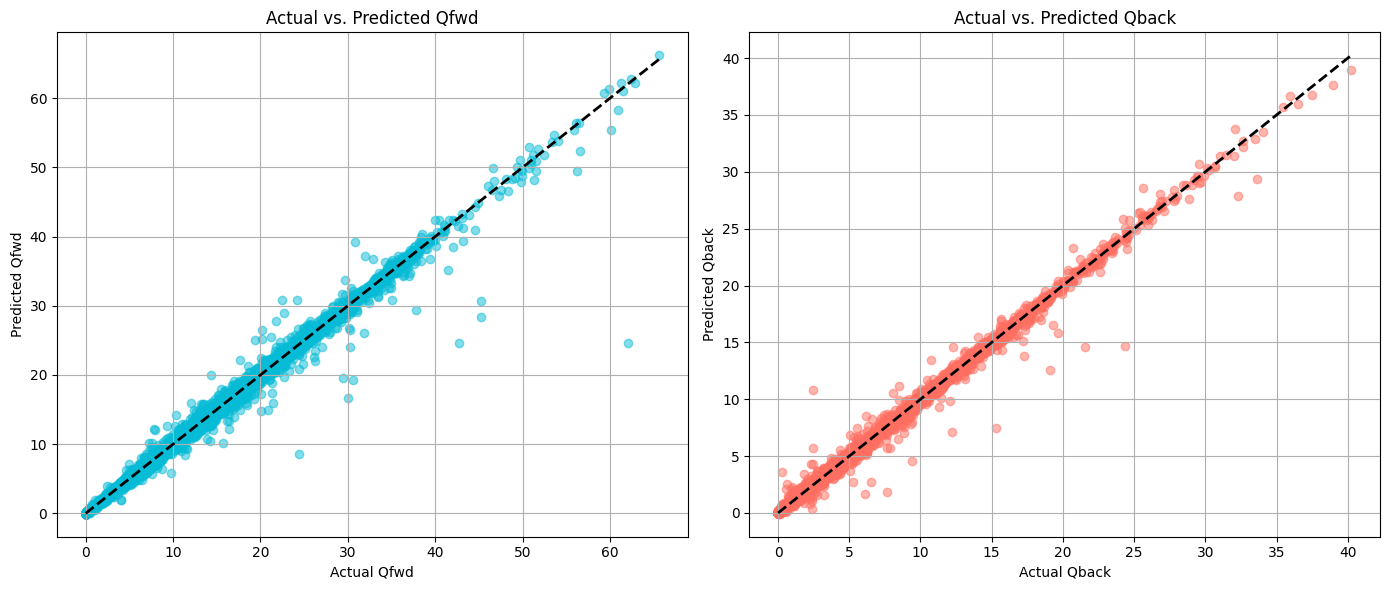

In [13]:
# Create a figure with two subplots for Qfwd and Qback
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Scatter plot for Qfwd
all_y_test = np.stack(df_test["Q_fwd"]).flatten()
all_y_pred = np.stack(df_test["Q_fwd_pred"]).flatten()

ax[0].scatter(all_y_test, all_y_pred, color="#06BBD6", alpha=0.5)
ax[0].plot(
    [all_y_test.min(), all_y_test.max()],
    [all_y_test.min(), all_y_test.max()],
    "k--",
    lw=2,
)
ax[0].set_xlabel("Actual Qfwd")
ax[0].set_ylabel("Predicted Qfwd")
ax[0].set_title("Actual vs. Predicted Qfwd")
ax[0].grid(True)

# Scatter plot for Qback
all_y_test = np.stack(df_test["Q_back"]).flatten()
all_y_pred = np.stack(df_test["Q_back_pred"]).flatten()

ax[1].scatter(all_y_test, all_y_pred, color="#FF6F61", alpha=0.5)
ax[1].plot(
    [all_y_test.min(), all_y_test.max()],
    [all_y_test.min(), all_y_test.max()],
    "k--",
    lw=2,
)
ax[1].set_xlabel("Actual Qback")
ax[1].set_ylabel("Predicted Qback")
ax[1].set_title("Actual vs. Predicted Qback")
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Forward statistics

In [14]:
# convert dataframe columns to numpy
qfwd_actual = np.stack(df_test["Q_fwd"])
qfwd_predicted = np.stack(df_test["Q_fwd_pred"])
qback_actual = np.stack(df_test["Q_back"])
qback_predicted = np.stack(df_test["Q_back_pred"])

# Calculate performance metrics for Qfwd
mse_Qfwd = np.abs(qfwd_actual - qfwd_predicted) ** 2
mae_Qfwd = np.abs(qfwd_actual - qfwd_predicted)
mse_Qback = np.abs(qback_actual - qback_predicted) ** 2
mae_Qback = np.abs(qback_actual - qback_predicted)

# Print the results
print(f"Test Set Performance for Qfwd:")
print(f"Mean Absolute Error (MAE): {mae_Qfwd.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qfwd.mean():.6f}")

print(f"\nTest Set Performance for Qback:")
print(f"Mean Absolute Error (MAE): {mae_Qback.mean():.6f}")
print(f"Mean Squared Error (MSE): {mse_Qback.mean():.6f}")

Test Set Performance for Qfwd:
Mean Absolute Error (MAE): 0.047831
Mean Squared Error (MSE): 0.040903

Test Set Performance for Qback:
Mean Absolute Error (MAE): 0.020682
Mean Squared Error (MSE): 0.007194


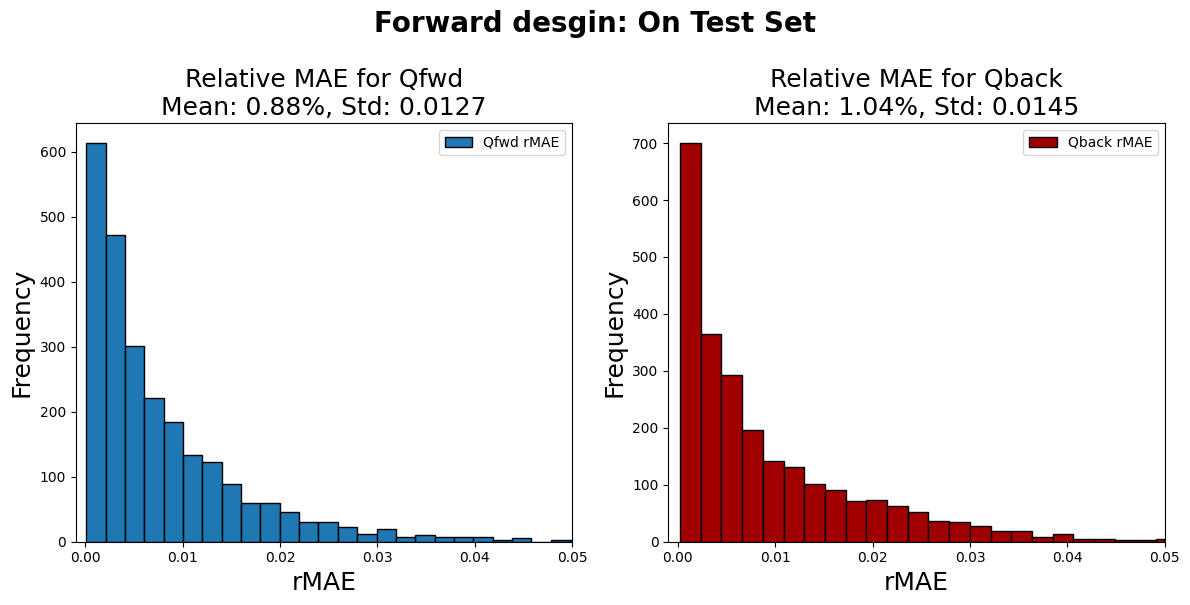

In [18]:
# absolute percentage error
mape_Qfwd = mae_Qfwd.mean(axis=1) / qfwd_actual.mean()
mape_Qback = mae_Qback.mean(axis=1) / qback_actual.mean()

# Plot histograms of MAE for Qfwd and Qback
plt.figure(figsize=(12, 6))
plt.suptitle("Forward desgin: On Test Set", fontweight="bold", fontsize=20, y=1.00)

# Plot the Qfwd MAE distribution
plt.subplot(1, 2, 1)
plt.hist(
    mape_Qfwd,
    bins=100,
    color="#1f77b4ff",
    label="Qfwd rMAE",
    edgecolor="black",
    alpha=1,
)
plt.title(
    f"Relative MAE for Qfwd\nMean: {100*mape_Qfwd.mean():.2f}%, Std: {mape_Qfwd.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.001, 0.05])

# Plot the Qback MAE distribution
plt.subplot(1, 2, 2)
plt.hist(
    mape_Qback,
    bins=100,
    color="#a00000ff",
    label="Qback rMAE",
    edgecolor="black",
    alpha=1,
)
plt.title(
    f"Relative MAE for Qback\nMean: {100*mape_Qback.mean():.2f}%, Std: {mape_Qback.std():.4f}",
    fontsize=18,
)
plt.xlabel("rMAE", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.xlim([-0.001, 0.05])

plt.tight_layout()
plt.show()

### Testing Plot Predicted vs Mie
---

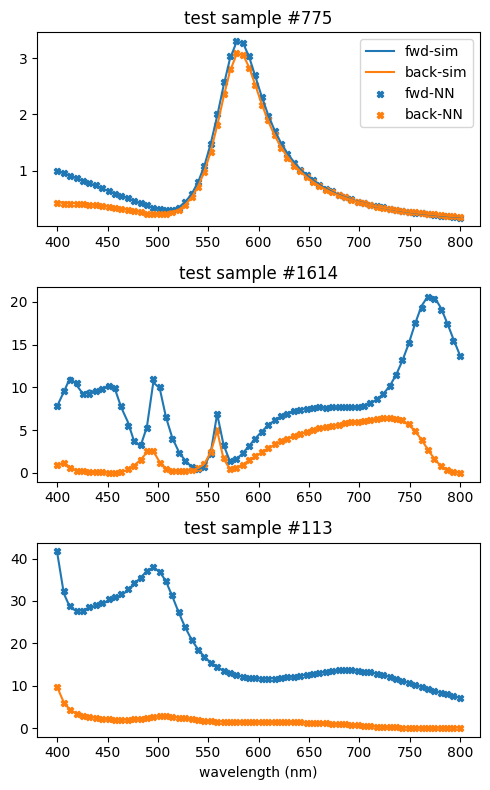

In [16]:
# Create a figure with subplots for the three configurations
plt.figure(figsize=(5, 8))
for i, d in enumerate(np.random.choice(len(df_test), 3)):
    plt.subplot(3, 1, i + 1, title=f"test sample #{d}")
    plt.plot(df_test["wavelength"][d], df_test["Q_fwd"][d], label="fwd-sim")
    plt.plot(df_test["wavelength"][d], df_test["Q_back"][d], label="back-sim")
    plt.scatter(
        df_test["wavelength"][d],
        df_test["Q_fwd_pred"][d],
        label="fwd-NN",
        marker="X",
        s=20,
    )
    plt.scatter(
        df_test["wavelength"][d],
        df_test["Q_back_pred"][d],
        label="back-NN",
        marker="X",
        s=20,
    )
    if i == 0:
        plt.legend()
    if i == 2:
        plt.xlabel("wavelength (nm)")

plt.tight_layout()
plt.show()